# **Diving Into Convolutions**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, gzip, math, os, time, shutil

import torch
from torch import nn, tensor
from torch .utils.data import default_collate, DataLoader
from typing import Mapping
from pathlib import Path

from miniai.training import * # Modules have already been developed in previous NBs
from miniai.datasets import * # and, reside in separate Github repo.

mpl.rcParams['image.cmap'] = 'gray'

In [2]:
# Data path, same as earlier NBs
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'

with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid= map(tensor, [x_train, y_train, x_valid, y_valid])

## **A Primer on Convolutions**

[This paper on the math behind Convolutions](https://paperswithcode.com/method/convolution) states:

> A convolution is a type of matrix operation, consisting of a kernel, a small matrix of weights, that slides over input data performing element-wise multiplication with the part of the input it is on, then summing the results into an output.
>
> Intuitively, a convolution allows for weight sharing - reducing the number of effective parameters - and image translation (allowing for the same feature to be detected in different parts of the input space).

![title](imgs/convs.png)

In [3]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [4]:
# Storing training and validation datasets in tensors with new shapes to match the PIL form.
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [5]:
# Set output resolution
mpl.rcParams['figure.dpi'] = 40

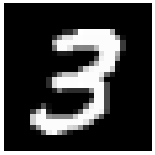

In [6]:
# Load a single image
im3 = x_imgs[7]
# Using the same show_image() function we created in nb_06
show_image(im3);

Let's create a 3x3 kernel to demonstrate how convolutions work.

For reference, [Wikipedia](https://en.wikipedia.org/wiki/Kernel_method) defines a Kernel method as: 

> Kernel methods owe their name to the use of kernel functions, which enable them to operate in a high-dimensional, implicit feature space without ever computing the coordinates of the data in that space, but rather by simply computing the inner products between the images of all pairs of data in the feature space. This operation is often computationally cheaper than the explicit computation of the coordinates. This approach is called the "kernel trick". Kernel functions have been introduced for sequence data, graphs, text, images, as well as vectors.



In [7]:
# Kernel to find / calculate values of top edges in image files
top_edge = tensor([[-1, -1, -1],
                   [ 0,  0,  0],
                   [ 1,  1,  1,]]).float()
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

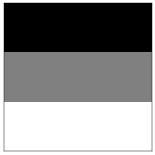

In [8]:
# Kernels can be visualized as well
show_image(top_edge, noframe=False);

Running a dot product on any window in our images, using this specific kernel can be illustrated as follows:

Imagine if ${A}$ is a window in any image:

$$
\mathbf{A} = \begin{bmatrix}
a_1 & a_2 & a_3 \\
a_4 & a_5 & a_6 \\
a_7 & a_8 & a_9
\end{bmatrix}
$$

and ${B}$ is the kernel matrix:

$$
\mathbf{B} = \begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

The end result will be based on the following values:

$-a_1$  $-a_2$ $-a_3$ $a_7$ $a_8$ $+a_9$






In [9]:
# Grabbing the first 13 rows and 23 cols of the image and visualizing them for effect.
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size': '10pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


Running a direct product on any 3x3 window and summing up will result in a large value.

In [10]:
# Take rows 3 to 5 and cols 14 to 16, multiply with the top_edge kernel and sum the results
(im3[3:6, 14:17] * top_edge).sum()

tensor(2.9727)

In [11]:
# Take rows 7 to 9 and cols 14 to 16, repeat the calculation
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [12]:
# Create a function which can replicate the calculation for any part of the image
def apply_kernel(row, col, kernel): return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [13]:
# Apply kernel to the center of the grid
apply_kernel(4, 15, top_edge)

tensor(2.9727)

The kernel calculations needs to take place over a sliding window in this instance.

![title](imgs/sliding_window.png)

Another handy way of representing the sliding window calculations is to use a nested list comprehension, which happens to be a very handy idiom:



In [14]:
[[(i, j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

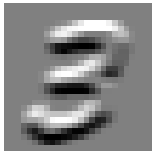

In [15]:
# Lets highlight the top edges, using a sliding window.
rng = range(1, 27) # dimensions
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3);

We can experiment with passing in a `left_edge` tensor as well.

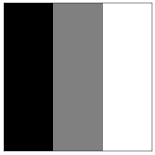

In [16]:
# Create left_edge tensor
left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()

show_image(left_edge, noframe=False);

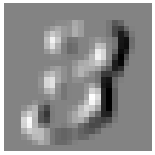

In [17]:
# Running the sliding window convolution from before
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3);

While this approach is handy for programmers like myself to understand how convolutions work, we should be cognizant of the fact that neural networks typically have numerous convolutional layers and creating kernel computations using list comprehensions, like the sliding window example above, is incredibly slow. 

We need to find a way to speed things up.

## **Convolutions in PyTorch**

In [18]:
import torch.nn.functional as F

One of the earlier optimizations to convolutions using GPUs came in 2015, by a computer scientist named [Yangqing Jia](https://scholar.google.com/citations?user=mu5Y2rYAAAAJ) in his blog post [Convolution in Caffe: A Memo](https://github.com/Yangqing/caffe/wiki/Convolution-in-Caffe:-a-memo).

The key takeaways are:

> The trick is to just lay out all the local patches, and organize them to a (W*H, K*K*D) matrix. In Matlab, this is usually known as an im2col operation. After that, consider the filters being a (M, K*K*D) matrix too, the convolution naturally gets reduced to a matrix multiplication (Gemm in BLAS) problem. We have awesome BLAS libraries such as MKL, Atlas, and CuBLAS, with impressive performances. This applies to GPUs as well, although GPU memory is indeed more "precious" than its CPU sibling. However, with reasonably large models such as ImageNet, Caffe has been working pretty OK. It is even able to process videos with such models, thanks to the recent advances in GPU hardware.
> 
> ...the lesson learned when writing Caffe as a grad student is simplicity: reduce my problem to one already solved. It sometimes burns, but could always be improved later if necessary.

This approach to addressing the convolution optimization problem was also covered in an even earlier paper titled [High Performance Convolutional Neural Networks for Document Processing](https://inria.hal.science/inria-00112631/). 

The authors depicted the convolution process as a special case of matrix multiplications - where kernels and input features can be un-rolled in matrices to carry out matmul operations to get to the correct outputs :

![title](imgs/im2col.png)


There is a Numpy implementation of this as well in the **[CNNumpy repo](https://github.com/3outeille/CNNumpy/blob/5394f13e7ed67a808a3e39fd381f168825d65ff5/src/fast/utils.py#L360).**

In [19]:
# The PyTorch implementation of this is called unfold()
# Note that PyTorch needs additional dimensions for the calculation to take place
# [batch, channel, rows, cols], so we will need to create unit dimensions accordingly.
inp = im3[None, None, :, :].float()
inp_unf = F.unfold(inp, kernel_size=(3, 3))[0]
inp_unf.shape

torch.Size([9, 676])

In [20]:
# Take the kernel and flatten it out into a vector. Using view(-1) to create a length 9 vector. 
w = left_edge.view(-1)
w.shape

torch.Size([9])

In [21]:
# Matrix multiplication of the altered tensors
out_unf = w @ inp_unf
out_unf.shape

torch.Size([676])

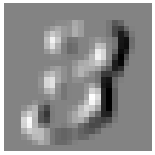

In [22]:
# Converting to 26x26 to view the left tensor result.
out = out_unf.view(26, 26)
show_image(out);

Let's see what kind of performance improvements these optimizations can give us.

In [23]:
%timeit -n 1 tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng]);

5.9 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit -n 100 (w @ F.unfold(inp, (3, 3))[0]).view(26, 26);

19.1 μs ± 9.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit -n 100 F.conv2d(inp, left_edge[None, None])

The slowest run took 10.64 times longer than the fastest. This could mean that an intermediate result is being cached.
20.2 μs ± 16.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Using unfold results in a ~400% increase in performance when compared to the nested list comprehensions.

Lets do the same for diagonal edges.

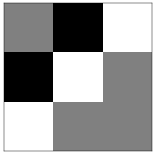

In [26]:
diag1_edge = tensor([[ 0, -1,  1],
                     [-1,  1,  0],
                     [ 1,  0,  0]]).float()

show_image(diag1_edge, noframe=False);

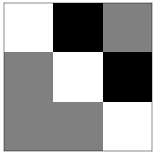

In [27]:
diag2_edge = tensor([[ 1, -1,  0],
                     [ 0,  1, -1],
                     [ 0,  0,  1]]).float()

show_image(diag2_edge, noframe=False);

In [28]:
# Create a batch of 16 
xb = x_imgs[:16][:, None]
xb.shape

torch.Size([16, 1, 28, 28])

In [29]:
# Lets stack all of our kernels in one object as another optimization
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [30]:
# Running the convolutions, with all the kernels we've created
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

So we end up with 16 images in our mini-batch, with 4 convolutional kernels, and 26x26 edge-maps. Note that one pixel from each side is lost during the convolution process and we'll cover how to handle that in a moment. 

Time to load a single image and its kernels. 

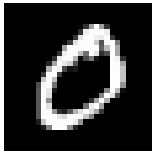

In [31]:
img0 = xb[1, 0]
show_image(img0);

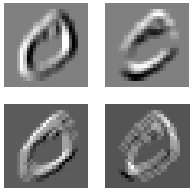

In [32]:
# Kernels
show_images([batch_features[1, i] for i in range(4)]);

## **Strides and Padding**

We need to be able to handle the loss of pixels during the convolution process. Padding allows us to ensure that the output activation map is the same size as the original image.

So with a 5x5 input, 4x4 kernel and 2 pixels of padding, the result is a 6x6 activation map.

![title](imgs/padding.png)

The standard practice for padding is to create a kernel `ks x ks` using odd numbers to get the same dimensions as our inputs.

Also, the figure depicts _stride-2_ convolutions which are useful for reducing the dimensionality of our input by a factor of 2. Lots of classification architectures utilize grid size reductions using stride-2 convolutions.

## **Creating the CNN**

Using what was learned, let's create our Convolutional Neural Network.

In [33]:
# Training set, categories and number of hidden activations
n, m = x_train.shape
c = y_train.max()+1
nh = 50

n, m ,c

(50000, 784, tensor(10))

In [34]:
# Previously, our Linear models were created using the following setup
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [35]:
# FYI the number of parameters in the MLP are 
tensor([np.prod(o.shape) for o in model.parameters()]).sum()

tensor(39760)

The MLP approach was dead simple given the number of inputs and outputs being specified above.

For convolutions, **we can't use a similar approach**, as shown in the cell below:

In [36]:
# This is not how a convolutional model will be setup
# since the output won't just be 10 probabilities for each item in the batch.
# Rather, it will be a 10 probabilities for each 28x28 image.
broken_cnn = nn.Sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 10, kernel_size=3, padding=1)
)

broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

First, lets create a flexible Conv function which can be used later as well.

In [37]:
def conv(num_in, num_filt, kernel_size=3, stride=2, activation=True):
    res = nn.Conv2d(num_in, num_filt, stride=stride, kernel_size=kernel_size, padding=kernel_size//2)
    # Returns Conv2d followed by ReLU
    if activation: res = nn.Sequential(res, nn.ReLU())
    return res

In [38]:
# Create a simple CNN
simple_cnn = nn.Sequential(
    conv(1, 4),                     # Grid = 14x14 since stride 2 conv.
    conv(4, 8),                     # 7x7          
    conv(8, 16),                    # 4x4
    conv(16, 16),                   # 2x2
    conv(16, 10, activation=False), #1x1 - creating 10 outputs
    nn.Flatten(),
)

In [39]:
# Now 16 images will have 10 probabilities each.
simple_cnn(xb).shape

torch.Size([16, 10])

In [40]:
# Lets check the number of parameters in the simple_cnn, but using np.numel() this time 
# tensor([o.numel() for o in simple_cnn.parameters()]).sum()

# Another version to handle generators
sum(o.numel() for o in simple_cnn.parameters())

5274

In [41]:
# Convert training and validation to 28x28
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
# Creating training and validation datasets
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [42]:
# Ensure that we're loading everthing onto the GPU
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    # Takes a tensor, list or dict and moves all items onto "device"
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b)) # After collation move tensors onto the device

In [43]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [44]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0 1.7865927267074584 0.2937000002384186
1 0.2546404341697693 0.9200000008583069
2 0.14470882902145385 0.9578000007629395
3 0.14372103400230407 0.9594999995231629
4 0.2665277552127838 0.9209999994277954


In [45]:
# Reducing learning rate by a factor of 4
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08620185956954957 0.9755999994277954
1 0.08468720598220825 0.9758999995231629
2 0.086282195854187 0.9763999994277954
3 0.09166572461128235 0.9739000008583069
4 0.08266830837726594 0.9768999994277954
